<a href="https://colab.research.google.com/github/Aryamaan777/Accident-Prediction/blob/master/TimeSeriesAndForecasting/ARIMA_vs_ML_Comparison_for_Return_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# --- 1. DATA PREPARATION ---
# We use a volatile stock to test the limits of both models
ticker = 'NVDA'
print(f"Downloading data for {ticker}...")
df = yf.download(ticker, start='2020-01-01', end='2024-01-01', progress=False)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# We predict Log Returns to make the data stationary (ARIMA requirement)
df['Close'] = df['Close'].ffill()
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)
df.head()

/tmp/ipython-input-483353490.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-01-01', progress=False)


Price,Close,High,Low,Open,Volume,Log_Ret
Date,,,,,,
2020-01-03,5.875504,5.919309,5.826473,5.851362,205384000,-0.016135
2020-01-06,5.900145,5.905372,5.756039,5.782172,262636000,0.004185
2020-01-07,5.971575,6.017371,5.883469,5.928518,314856000,0.012034
2020-01-08,5.982775,6.024091,5.927273,5.967344,277108000,0.001874
2020-01-09,6.048482,6.120909,5.994722,6.069140,255112000,0.010923


In [ ]:
# --- 2. CREATE FEATURES (Only for ML) ---
# ARIMA only looks at "Log_Ret". XGBoost gets helper features.
df['Vol_5'] = df['Log_Ret'].rolling(5).std()
df['Mom_10'] = df['Close'].pct_change(10)
df['RSI_Proxy'] = df['Close'] / df['Close'].rolling(14).mean()
df.dropna(inplace=True)

# Train/Test Split
split = int(len(df) * 0.9)
train_data = df.iloc[:split]
test_data = df.iloc[split:]

In [ ]:
print(split)

892


In [ ]:
# --- 3. MODEL 1: ARIMA (The Statistical Benchmark) ---
# We use a Walk-Forward Loop because ARIMA needs to be re-calibrated
# or at least updated with the latest data point to predict the next step.
print("Training ARIMA (This loop takes a moment)...")

arima_preds = []
history = [x for x in train_data['Log_Ret'].values]

# We will just do a simple "Rolling Forecast" without re-training parameters every step to save time
# We fit once, then use the model to predict 1 step ahead, adding real data as we go.
# Order (5,0,0) = AR(5). We use d=0 because we already differenced (Log_Ret).
model_fit = ARIMA(history, order=(5,0,0)).fit()

# In a real rigorous test, we re-fit every day. Here we simulate the update.
for i in range(len(test_data)):
    # Forecast next step
    # (Simplified: In production, re-fit ARIMA every N days)
    output = model_fit.forecast()
    yhat = output[0]
    arima_preds.append(yhat)

    # Add actual observation to history (for next iteration if we were re-fitting)
    # For this simplified demo, we just append to list to track progress
    obs = test_data['Log_Ret'].iloc[i]
    history.append(obs)

    # Re-fit every 20 days to adapt to market regime
    if i % 20 == 0:
        model_fit = ARIMA(history, order=(5,0,0)).fit()

test_data['Pred_ARIMA'] = arima_preds

Training ARIMA (This loop takes a moment)...


/tmp/ipython-input-1313913378.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Pred_ARIMA'] = arima_preds


In [ ]:
# --- 4. MODEL 2: XGBOOST (The ML Challenger) ---
print("Training XGBoost...")

features = ['Vol_5', 'Mom_10', 'RSI_Proxy']

# Create Lags
for lag in range(1, 6):
    df[f'Lag_{lag}'] = df['Log_Ret'].shift(lag)
    features.append(f'Lag_{lag}')

# 1. DROP NAS FIRST (Clean the data)
df.dropna(inplace=True)

# 2. DEFINE SPLIT DATE (The anchor)
# Instead of an integer, we use the specific timestamp where ARIMA started testing
# (We grab the first index from the ARIMA test_data we created earlier)
split_date = test_data.index[0]

# 3. SPLIT BY DATE (Robust method)
# This ensures train/test align perfectly with the calendar
train_ml = df[df.index < split_date]
test_ml = df[df.index >= split_date]

# 4. TRAIN
model_xgb = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
model_xgb.fit(train_ml[features], train_ml['Log_Ret'])

# 5. PREDICT & ASSIGN SAFELY
# We use .loc to map predictions specifically to their dates
# This prevents "Length Mismatch" errors even if one array is shorter
preds = model_xgb.predict(test_ml[features])
test_data.loc[test_ml.index, 'Pred_ML'] = preds

# (Optional) Fill any missing predictions at the very start of the test set
# if alignment wasn't perfect
test_data['Pred_ML'] = test_data['Pred_ML'].fillna(0)

Training XGBoost...


/tmp/ipython-input-1026701117.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[test_ml.index, 'Pred_ML'] = preds
/tmp/ipython-input-1026701117.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Pred_ML'] = test_data['Pred_ML'].fillna(0)


In [ ]:
# --- 5. EVALUATION ---

# Convert back to Price for visual comparison (Cumulative Returns)
test_data['Cum_Ret_Actual'] = np.exp(test_data['Log_Ret'].cumsum())
test_data['Cum_Ret_ARIMA'] = np.exp(test_data['Pred_ARIMA'].cumsum())
test_data['Cum_Ret_ML'] = np.exp(test_data['Pred_ML'].cumsum())

# Metrics (RMSE on Log Returns)
rmse_arima = np.sqrt(mean_squared_error(test_data['Log_Ret'], test_data['Pred_ARIMA']))
rmse_ml = np.sqrt(mean_squared_error(test_data['Log_Ret'], test_data['Pred_ML']))

print("\n--- RESULTS ---")
print(f"ARIMA RMSE:   {rmse_arima:.5f}")
print(f"XGBoost RMSE: {rmse_ml:.5f}")


--- RESULTS ---
ARIMA RMSE:   0.02328
XGBoost RMSE: 0.01914


/tmp/ipython-input-502529156.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Cum_Ret_Actual'] = np.exp(test_data['Log_Ret'].cumsum())
/tmp/ipython-input-502529156.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Cum_Ret_ARIMA'] = np.exp(test_data['Pred_ARIMA'].cumsum())
/tmp/ipython-input-502529156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

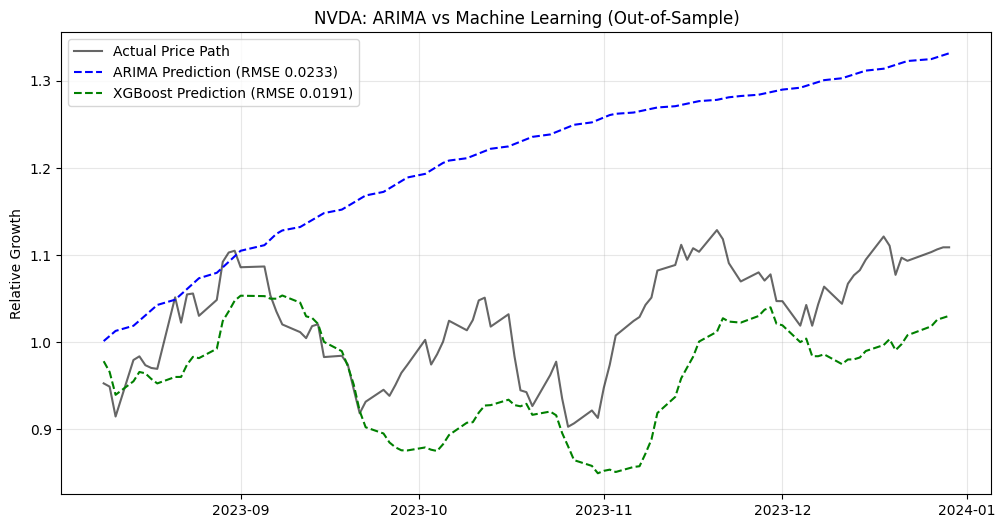

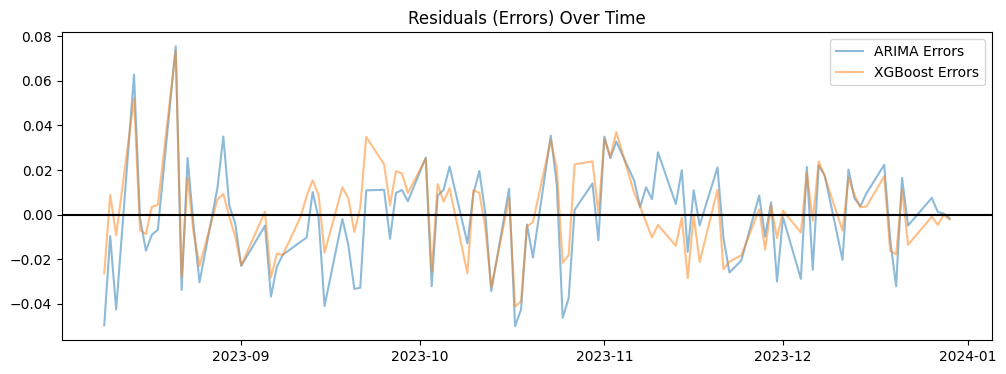

In [ ]:
# --- 6. PLOT ---
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Cum_Ret_Actual'], label='Actual Price Path', color='black', alpha=0.6)
plt.plot(test_data.index, test_data['Cum_Ret_ARIMA'], label=f'ARIMA Prediction (RMSE {rmse_arima:.4f})', color='blue', linestyle='--')
plt.plot(test_data.index, test_data['Cum_Ret_ML'], label=f'XGBoost Prediction (RMSE {rmse_ml:.4f})', color='green', linestyle='--')

plt.title(f"{ticker}: ARIMA vs Machine Learning (Out-of-Sample)")
plt.ylabel("Relative Growth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Residual Analysis
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, test_data['Log_Ret'] - test_data['Pred_ARIMA'], label='ARIMA Errors', alpha=0.5)
plt.plot(test_data.index, test_data['Log_Ret'] - test_data['Pred_ML'], label='XGBoost Errors', alpha=0.5)
plt.title("Residuals (Errors) Over Time")
plt.axhline(0, color='black')
plt.legend()
plt.show()